In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import scrublet as scr
import anndata as ad
import sys
import bbknn
from statsmodels import robust
import matplotlib.pyplot as plt
import os.path
import harmonypy as hm

import celltypist
from celltypist import models

import muon as mu
from muon import MuData

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
#sc.settings.set_figure_params(dpi=80, color_map='viridis')
#sc.logging.print_versions()

In [2]:
input_file = '/lustre/scratch126/cellgen/team205/rl20/T_cell_lym/object/Subset_Tcell_final_soupX_processed_noBatchC.h5ad'
adata1 = sc.read_h5ad(input_file)

In [3]:
adata1 = adata1.raw.to_adata()
adata1.X.expm1().sum(axis = 1)

matrix([[ 9999.999],
        [ 9999.999],
        [10000.   ],
        ...,
        [10000.   ],
        [10000.001],
        [10000.002]], dtype=float32)

In [4]:
adata1.obs['malignant_call_donor'].value_counts()

benign                 35931
malig_TL5521           16840
malig_TL6678           13006
malig_TL5968           12396
malig_TL_SJH03         10451
malig_TL_KLT           10172
malig_TL5493            8514
malig_TL4528            3118
malig_TL3291            2841
malig_TL_MTK            2739
malig_TL8441            2240
malig_TL_MAP006         1609
malig_TL10712           1541
malig_TL5737             600
malig_TL6722             510
malig_TL2860             338
malig_TL_Mangosteen      295
malig_TL6042              38
malig_TL6682              15
Name: malignant_call_donor, dtype: int64

In [5]:
adata1_sub = adata1[adata1.obs['malignant_call_donor'].isin(['malig_TL5737','malig_TL5968',
                                                             'malig_TL3291'])].copy()
adata1_sub

AnnData object with n_obs × n_vars = 15837 × 30472
    obs: 'ID', 'sample_id', 'donor_id', 'tumour_type', 'age', 'site', 'type', 'mad_prd', 'ds', 'mad_MED', 'mad_MAD', 'mad_thr', 'n_genes', 'percent_mito', 'percent_ribo', 'n_counts', 'leiden_0.8', 'leiden_1.0', 'leiden_1.0_c14', 'leiden_1.0_c14_C15', 'broad_cell_type', 'leiden_0.8_c22', 'leiden_0.8_c22_c3', 'malignant_call', 'malignant_call_donor', 'malignant_call_tumour_type'
    var: 'gene_ids', 'n_cells'
    uns: 'broad_cell_type_colors', 'dendrogram_leiden_0.8', 'dendrogram_leiden_1.0_c14', 'dendrogram_leiden_1.0_c14_C15', 'donor_id_colors', 'hvg', 'leiden', 'leiden_0.8_c22_c3_colors', 'leiden_0.8_c22_colors', 'leiden_0.8_colors', 'leiden_1.0_c14_C15_colors', 'leiden_1.0_c14_colors', 'leiden_1.0_colors', 'malignant_call_colors', 'neighbors', 'pca', 'rank_genes_groups', 'tumour_type_colors', 'umap'
    obsm: 'X_pca', 'X_pca_back', 'X_umap'
    obsp: 'connectivities', 'distances'

In [6]:
input_file = '/lustre/scratch126/cellgen/team205/rl20/T_cell_lym/download_object/HTA08_v01_A06_Science_human_tcells.h5ad'
adata2 = sc.read_h5ad(input_file)

In [7]:
adata2.obs['donor_id'] = adata2.obs['donor']

In [8]:
adata2_sub = adata2[adata2.obs['cell types'].isin(['DN(early)'])].copy()
adata2_sub

AnnData object with n_obs × n_vars = 1260 × 33694
    obs: 'Sample', 'donor', 'organ', 'sort', 'method', 'file', 'is_TRA_p', 'is_TRB_p', 'is_TRA_np', 'is_TRB_np', 'Age', 'Source', 'cell types', 'donor_id'
    var: 'gene_id'
    obsm: 'X_umap', 'X_umap_3d'

In [9]:
adata2_sub.obs['donor'].value_counts()

F45    326
P1     144
P3     118
F41     99
C40     86
P2      72
F21     66
F30     59
T03     51
T06     46
F38     33
F23     31
F64     31
T07     26
C41     23
F74     19
F83     12
C34      9
F29      7
F22      2
Name: donor, dtype: int64

In [10]:
adata2_sub = adata2_sub[~adata2_sub.obs['donor'].isin(['C34','F29','F22'])].copy()

In [11]:
adatas = [adata1_sub, adata2_sub]

In [12]:
adata = adatas[0].concatenate(adatas[1:], join = 'inner', index_unique='-')

In [13]:
adata

AnnData object with n_obs × n_vars = 17079 × 19839
    obs: 'ID', 'sample_id', 'donor_id', 'tumour_type', 'age', 'site', 'type', 'mad_prd', 'ds', 'mad_MED', 'mad_MAD', 'mad_thr', 'n_genes', 'percent_mito', 'percent_ribo', 'n_counts', 'leiden_0.8', 'leiden_1.0', 'leiden_1.0_c14', 'leiden_1.0_c14_C15', 'broad_cell_type', 'leiden_0.8_c22', 'leiden_0.8_c22_c3', 'malignant_call', 'malignant_call_donor', 'malignant_call_tumour_type', 'Sample', 'donor', 'organ', 'sort', 'method', 'file', 'is_TRA_p', 'is_TRB_p', 'is_TRA_np', 'is_TRB_np', 'Age', 'Source', 'cell types', 'batch'
    var: 'gene_ids-0', 'n_cells-0', 'gene_id-1'
    obsm: 'X_umap'

In [14]:
adata.obs['malignant_call'].value_counts()

malig    15837
Name: malignant_call, dtype: int64

In [15]:
pd.isna(adata.obs['malignant_call']).value_counts()

False    15837
True      1242
Name: malignant_call, dtype: int64

In [16]:
adata.obs.loc[pd.isna(adata.obs['malignant_call']), 'malignant_call'] = 'benign'

In [17]:
malignant_call_donor = [i + '_' +j for i, j in zip(list(adata.obs['malignant_call']), list(adata.obs['donor_id']))]
adata.obs['malignant_call_donor'] = malignant_call_donor
adata.obs['malignant_call_donor2'] = malignant_call_donor

adata.obs.loc[~adata.obs['malignant_call_donor2'].isin(['malig_TL5968','malig_TL3291','malig_TL5737']),
              'malignant_call_donor2'] = 'benign_DN'

adata.obs['malignant_call_donor2'].value_counts()

malig_TL5968    12396
malig_TL3291     2841
benign_DN        1242
malig_TL5737      600
Name: malignant_call_donor2, dtype: int64

ranking genes


... storing 'ID' as categorical
... storing 'sample_id' as categorical
... storing 'donor_id' as categorical
... storing 'tumour_type' as categorical
... storing 'age' as categorical
... storing 'site' as categorical
... storing 'type' as categorical
... storing 'leiden_0.8' as categorical
... storing 'leiden_1.0' as categorical
... storing 'leiden_1.0_c14' as categorical
... storing 'leiden_1.0_c14_C15' as categorical
... storing 'broad_cell_type' as categorical
... storing 'leiden_0.8_c22' as categorical
... storing 'leiden_0.8_c22_c3' as categorical
... storing 'malignant_call' as categorical
... storing 'malignant_call_donor' as categorical
... storing 'malignant_call_tumour_type' as categorical
... storing 'Sample' as categorical
... storing 'donor' as categorical
... storing 'organ' as categorical
... storing 'sort' as categorical
... storing 'method' as categorical
... storing 'file' as categorical
... storing 'Age' as categorical
... storing 'Source' as categorical
... storing 

    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:27)


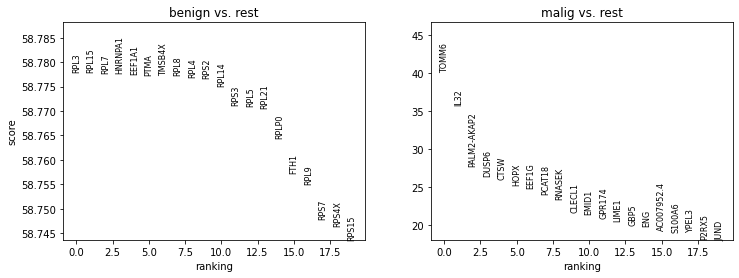

In [18]:
sc.tl.rank_genes_groups(adata, 'malignant_call', method = 'wilcoxon',n_genes=200)
sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False)
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
markers = pd.DataFrame(
{group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals_adj', 'logfoldchanges']})

In [19]:
markers.to_csv('/home/jovyan/farm/T-cell_lym/malignant_markers/malignant_DEGs_all_TLBL_vs_DN_early_top200.csv')

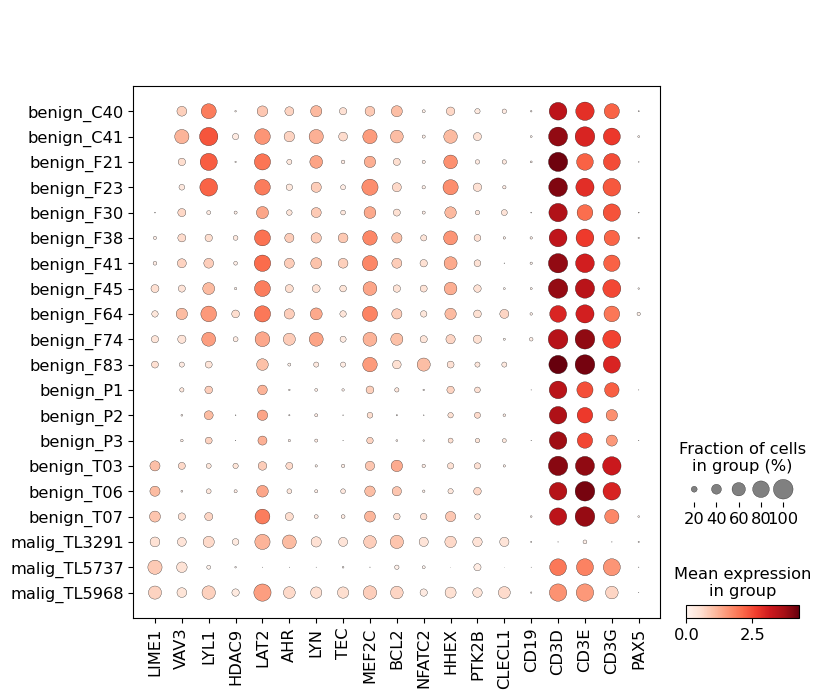

In [21]:
genes = ['LIME1','VAV3','LYL1','HDAC9','LAT2','AHR','LYN','TEC','MEF2C','BCL2',
         'NFATC2','HHEX','PTK2B','CLECL1','CD19','CD3D','CD3E','CD3G','PAX5']

sc.settings.set_figure_params(dpi=50, facecolor='white')
dp = sc.pl.dotplot(adata,
                   genes, groupby='malignant_call_donor',dendrogram=False, color_map='Reds')

### With pan-fetal

In [2]:
input_file = '/lustre/scratch126/cellgen/team205/rl20/T_cell_lym/object/Subset_Tcell_final_soupX_processed_noBatchC.h5ad'
adata1 = sc.read_h5ad(input_file)

In [3]:
adata1 = adata1.raw.to_adata()
adata1.X.expm1().sum(axis = 1)

matrix([[ 9999.999],
        [ 9999.999],
        [10000.   ],
        ...,
        [10000.   ],
        [10000.001],
        [10000.002]], dtype=float32)

In [4]:
adata1_sub = adata1[adata1.obs['malignant_call_donor'].isin(['malig_TL5737','malig_TL5968',
                                                             'malig_TL3291'])].copy()
adata1_sub

AnnData object with n_obs × n_vars = 15837 × 30472
    obs: 'ID', 'sample_id', 'donor_id', 'tumour_type', 'age', 'site', 'type', 'mad_prd', 'ds', 'mad_MED', 'mad_MAD', 'mad_thr', 'n_genes', 'percent_mito', 'percent_ribo', 'n_counts', 'leiden_0.8', 'leiden_1.0', 'leiden_1.0_c14', 'leiden_1.0_c14_C15', 'broad_cell_type', 'leiden_0.8_c22', 'leiden_0.8_c22_c3', 'malignant_call', 'malignant_call_donor', 'malignant_call_tumour_type'
    var: 'gene_ids', 'n_cells'
    uns: 'broad_cell_type_colors', 'dendrogram_leiden_0.8', 'dendrogram_leiden_1.0_c14', 'dendrogram_leiden_1.0_c14_C15', 'donor_id_colors', 'hvg', 'leiden', 'leiden_0.8_c22_c3_colors', 'leiden_0.8_c22_colors', 'leiden_0.8_colors', 'leiden_1.0_c14_C15_colors', 'leiden_1.0_c14_colors', 'leiden_1.0_colors', 'malignant_call_colors', 'neighbors', 'pca', 'rank_genes_groups', 'tumour_type_colors', 'umap'
    obsm: 'X_pca', 'X_pca_back', 'X_umap'
    obsp: 'connectivities', 'distances'

In [5]:
input_file = '/lustre/scratch126/cellgen/team205/rl20/T_cell_lym/download_object/PAN.A01.v01.raw_count.20210429.NKT.embedding.h5ad'
adata2 = sc.read_h5ad(input_file)

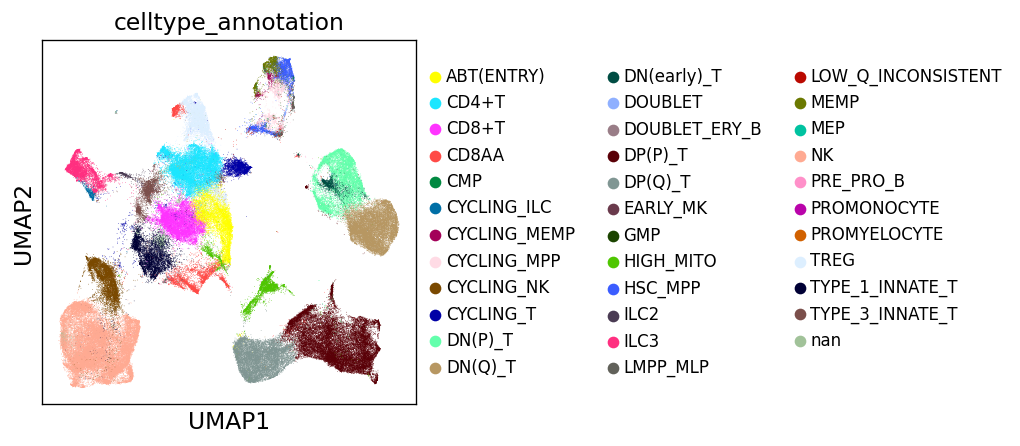

In [6]:
sc.settings.set_figure_params(dpi=60, facecolor='white')
sc.pl.umap(adata2, color=['celltype_annotation'],legend_fontsize=10)

In [7]:
adata2.obs['donor_id'] = adata2.obs['donor'].copy()

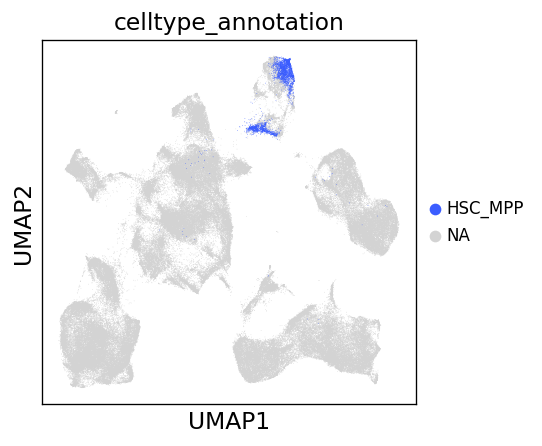

In [9]:
sc.settings.set_figure_params(dpi=60, facecolor='white')
sc.pl.umap(adata2, color=['celltype_annotation'], legend_fontsize=10 ,groups=['HSC_MPP'])

In [8]:
adata2_sub = adata2[adata2.obs['celltype_annotation'].isin(['DN(early)_T','DN(P)_T','DN(Q)_T'])].copy()


In [10]:
adata2_sub = adata2_sub[adata2_sub.obs['donor'].isin(['F45','F41','F21',
                                                      'F30','F38','F23',
                                                      'F67','F64','F61','F29','F32'])].copy() ### only >10 cells

In [11]:
sc.pp.normalize_per_cell(adata2_sub, counts_per_cell_after = 1e4)
sc.pp.log1p(adata2_sub)

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


In [12]:
adatas = [adata1_sub, adata2_sub]
adata = adatas[0].concatenate(adatas[1:], join = 'inner', index_unique='-')
adata

AnnData object with n_obs × n_vars = 40901 × 26899
    obs: 'ID', 'sample_id', 'donor_id', 'tumour_type', 'age', 'site', 'type', 'mad_prd', 'ds', 'mad_MED', 'mad_MAD', 'mad_thr', 'n_genes', 'percent_mito', 'percent_ribo', 'n_counts', 'leiden_0.8', 'leiden_1.0', 'leiden_1.0_c14', 'leiden_1.0_c14_C15', 'broad_cell_type', 'leiden_0.8_c22', 'leiden_0.8_c22_c3', 'malignant_call', 'malignant_call_donor', 'malignant_call_tumour_type', 'file', 'mito', 'doublet_scores', 'predicted_doublets', 'old_annotation_uniform', 'organ', 'Sort_id', 'method', 'donor', 'sex', 'Sample', 'scvi_clusters', 'is_maternal_contaminant', 'anno_lvl_2_final_clean', 'celltype_annotation', 'batch'
    var: 'gene_ids-0', 'n_cells-0', 'GeneID-1', 'GeneName-1', 'highly_variable-1', 'means-1', 'dispersions-1', 'dispersions_norm-1', 'scvi_model_var-1'
    obsm: 'X_umap'

In [13]:
adata.obs['malignant_call'].value_counts()

malig    15837
Name: malignant_call, dtype: int64

In [14]:
adata.obs.loc[pd.isna(adata.obs['malignant_call']), 'malignant_call'] = 'benign'

malignant_call_donor = [i + '_' +j for i, j in zip(list(adata.obs['malignant_call']), list(adata.obs['donor_id']))]
adata.obs['malignant_call_donor'] = malignant_call_donor
adata.obs['malignant_call_donor2'] = malignant_call_donor

adata.obs.loc[~adata.obs['malignant_call_donor2'].isin(['malig_TL5968','malig_TL3291','malig_TL5737']),
              'malignant_call_donor2'] = 'benign_DN'

adata.obs['malignant_call_donor2'].value_counts()

benign_DN       25064
malig_TL5968    12396
malig_TL3291     2841
malig_TL5737      600
Name: malignant_call_donor2, dtype: int64

ranking genes


... storing 'ID' as categorical
... storing 'sample_id' as categorical
... storing 'donor_id' as categorical
... storing 'tumour_type' as categorical
... storing 'site' as categorical
... storing 'type' as categorical
... storing 'leiden_0.8' as categorical
... storing 'leiden_1.0' as categorical
... storing 'leiden_1.0_c14' as categorical
... storing 'leiden_1.0_c14_C15' as categorical
... storing 'broad_cell_type' as categorical
... storing 'leiden_0.8_c22' as categorical
... storing 'leiden_0.8_c22_c3' as categorical
... storing 'malignant_call' as categorical
... storing 'malignant_call_donor' as categorical
... storing 'malignant_call_tumour_type' as categorical
... storing 'file' as categorical
... storing 'predicted_doublets' as categorical
... storing 'old_annotation_uniform' as categorical
... storing 'organ' as categorical
... storing 'Sort_id' as categorical
... storing 'method' as categorical
... storing 'donor' as categorical
... storing 'sex' as categorical
... storing 'S

    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:29)


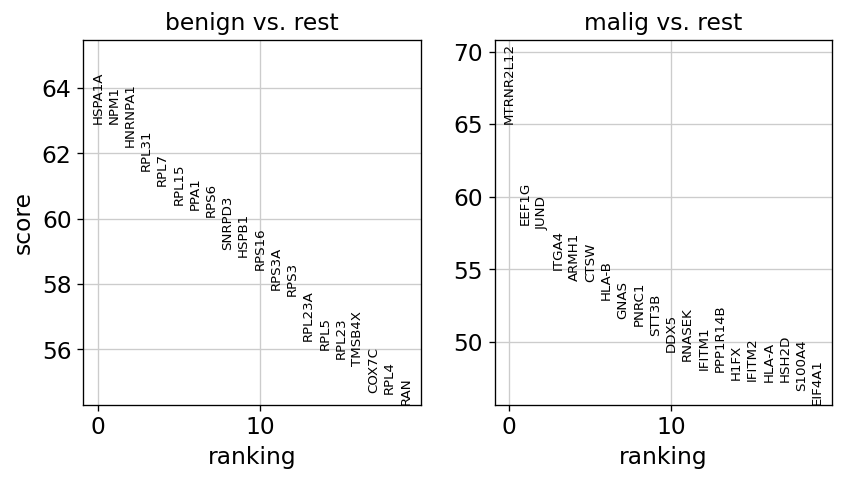

In [15]:
sc.tl.rank_genes_groups(adata, 'malignant_call', method = 'wilcoxon',n_genes=200)
sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False)
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
markers = pd.DataFrame(
{group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals_adj', 'logfoldchanges']})

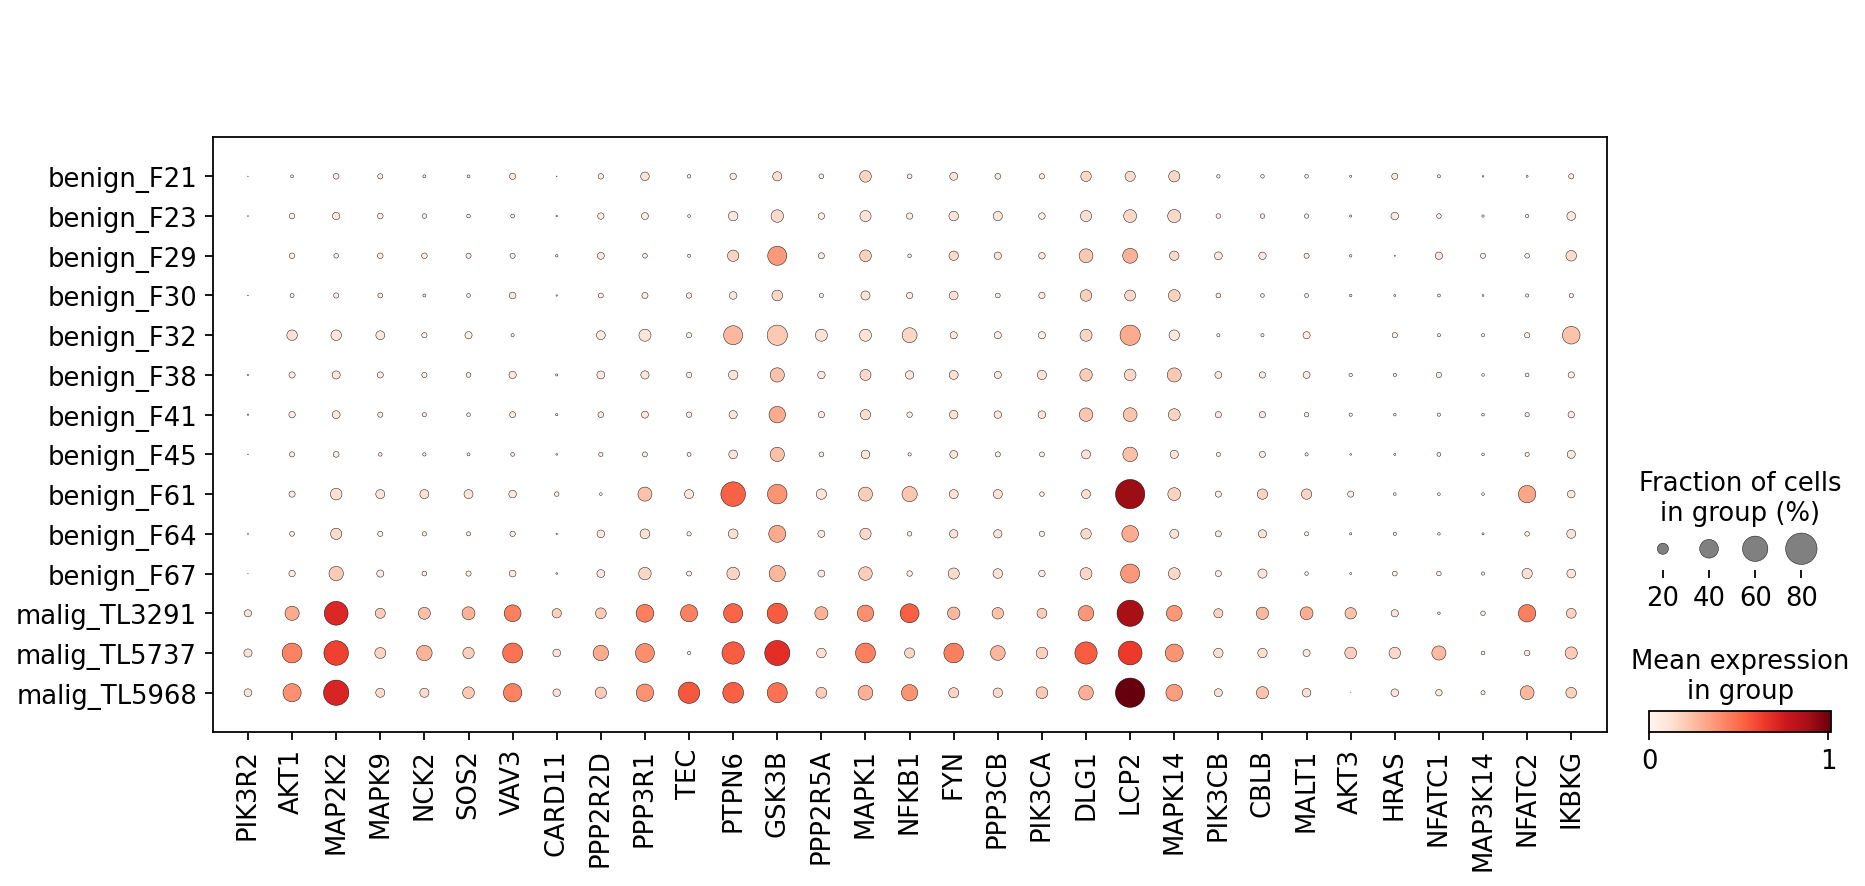

In [50]:
genes = ['PIK3R2','AKT1','MAP2K2','MAPK9','NCK2','SOS2','VAV3',
         'CARD11','PPP2R2D','PPP3R1','TEC','PTPN6','GSK3B','PPP2R5A',
         'MAPK1','NFKB1','FYN','PPP3CB','PIK3CA','DLG1','LCP2','MAPK14',
         'PIK3CB','CBLB','MALT1','AKT3','HRAS','NFATC1',
         'MAP3K14','NFATC2','IKBKG']

sc.settings.set_figure_params(dpi=80, facecolor='white')
dp = sc.pl.dotplot(adata,
                   genes, groupby='malignant_call_donor',dendrogram=False, color_map='Reds')

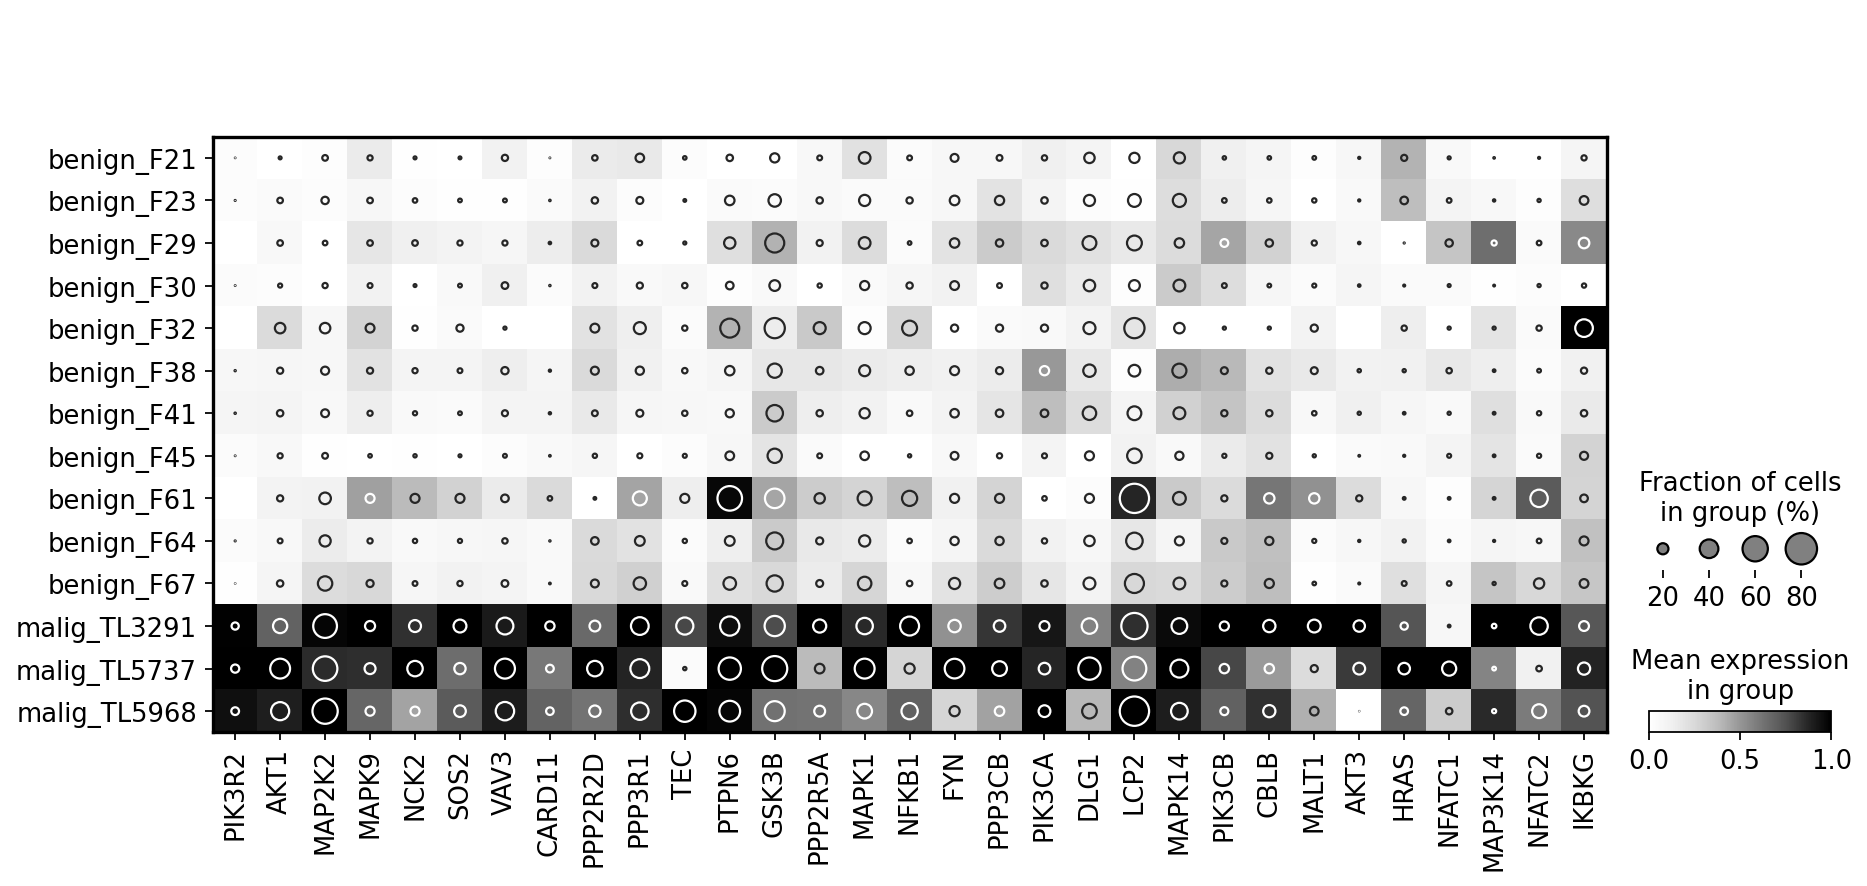

In [47]:
dp = sc.pl.dotplot(adata, var_names=genes, groupby='malignant_call_donor',dendrogram=False,
                   var_group_rotation=0, swap_axes=False,standard_scale = 'var',
                   return_fig=True)
dp.style(cmap='Greys',color_on='square',dot_edge_color=None,dot_edge_lw=1)
dp.savefig('/home/jovyan/farm/T-cell_lym/script/figures/DEGs_TCR_signaling_KEGG_malignant_DNT.pdf')

In [17]:
markers.to_csv('/home/jovyan/farm/T-cell_lym/malignant_markers/malignant_DEGs_all_TLBL_vs_DN_early_panfetal_top200.csv')

### Integrated raw for pseudobulk

In [48]:
input_file = '/lustre/scratch126/cellgen/team205/rl20/T_cell_lym/object/TCL_final_malignantT_raw_ENSG.h5ad'
adata1 = sc.read_h5ad(input_file)

In [49]:
adata1.var.index = adata1.var['gene_ids']
adata1.var

,gene_ids,ensg_id
gene_ids,,
MIR1302-2HG,MIR1302-2HG,ENSG00000243485
FAM138A,FAM138A,ENSG00000237613
OR4F5,OR4F5,ENSG00000186092
AL627309.1,AL627309.1,ENSG00000238009
AL627309.3,AL627309.3,ENSG00000239945
...,...,...
AC141272.1,AC141272.1,ENSG00000277836
AC023491.2,AC023491.2,ENSG00000278633
AC007325.1,AC007325.1,ENSG00000276017


In [50]:
malignant_call_donor = [i + '_' +j for i, j in zip(list(adata1.obs['malignant_call']), list(adata1.obs['donor_id']))]
adata1.obs['malignant_call_donor'] = malignant_call_donor
adata1.obs['malignant_call_donor'].value_counts()

malig_TL5521           16840
malig_TL6678           13006
malig_TL5968           12396
malig_TL_SJH03         10451
malig_TL_KLT           10172
malig_TL5493            8514
malig_TL4528            3118
malig_TL3291            2841
malig_TL_MTK            2739
malig_TL8441            2240
malig_TL_MAP006         1609
malig_TL10712           1541
malig_TL5737             600
malig_TL6722             510
malig_TL2860             338
malig_TL_Mangosteen      295
malig_TL6042              38
malig_TL6682              15
Name: malignant_call_donor, dtype: int64

In [51]:
adata1_sub = adata1[adata1.obs['malignant_call_donor'].isin(['malig_TL5737','malig_TL5968',
                                                             'malig_TL3291'])].copy()

In [52]:
input_file = '/lustre/scratch126/cellgen/team205/rl20/T_cell_lym/download_object/PAN.A01.v01.raw_count.20210429.NKT.embedding.h5ad'
adata2 = sc.read_h5ad(input_file)

In [53]:
adata2.obs['donor_id'] = adata2.obs['donor'].copy()

In [54]:
adata2.obs['celltype_annotation'].value_counts()

NK                    30284
DP(P)_T               22839
DN(Q)_T               13655
CD4+T                 13649
DP(Q)_T               12390
DN(P)_T                9803
CD8+T                  9369
ABT(ENTRY)             7066
CYCLING_NK             7052
TREG                   6850
ILC3                   5931
TYPE_1_INNATE_T        5727
CD8AA                  4737
HIGH_MITO              4339
HSC_MPP                3348
TYPE_3_INNATE_T        3031
CYCLING_T              2985
CYCLING_MPP            2240
nan                    2086
MEMP                   1762
DN(early)_T            1654
LMPP_MLP                813
CYCLING_ILC             541
CYCLING_MEMP            535
ILC2                    468
DOUBLET                 232
LOW_Q_INCONSISTENT      173
CMP                     167
PRE_PRO_B               153
DOUBLET_ERY_B           128
MEP                      89
GMP                      88
EARLY_MK                 67
PROMYELOCYTE              8
PROMONOCYTE               2
Name: celltype_annot

In [55]:
adata2_sub = adata2[adata2.obs['celltype_annotation'].isin(['DN(early)_T','DN(Q)_T','DN(P)_T'])].copy()


In [56]:
adata2_sub.obs['donor_id'].value_counts()

F45    12547
F41     3244
F21     2859
F30     1605
F23     1374
F38     1266
F64     1256
F67      741
F29      112
F61       33
F32       27
F51        9
F35        9
F78        8
F50        6
F34        5
F72        4
F22        3
F33        2
F66        1
F71        1
Name: donor_id, dtype: int64

In [57]:
adata2_sub = adata2_sub[adata2_sub.obs['donor_id'].isin(['F45','F41','F21',
                                                      'F30','F38','F23',
                                                      'F67','F64','F61','F29','F32'])].copy() ### only >10 cells

In [58]:
adatas = [adata1_sub, adata2_sub]
adata = adatas[0].concatenate(adatas[1:], join = 'inner', index_unique='-')
adata

AnnData object with n_obs × n_vars = 40901 × 31908
    obs: 'sample_id', 'donor_id', 'tumour_type', 'broad_cell_type', 'malignant_call', 'study', 'malignant_call_donor', 'n_counts', 'n_genes', 'file', 'mito', 'doublet_scores', 'predicted_doublets', 'old_annotation_uniform', 'organ', 'Sort_id', 'age', 'method', 'donor', 'sex', 'Sample', 'scvi_clusters', 'is_maternal_contaminant', 'anno_lvl_2_final_clean', 'celltype_annotation', 'batch'
    var: 'gene_ids-0', 'ensg_id-0', 'GeneID-1', 'GeneName-1', 'highly_variable-1', 'means-1', 'dispersions-1', 'dispersions_norm-1', 'scvi_model_var-1'

In [59]:
adata.obs['malignant_call'].value_counts()

malig    15837
Name: malignant_call, dtype: int64

In [60]:
adata.obs.loc[pd.isna(adata.obs['malignant_call']), 'malignant_call'] = 'benign'

malignant_call_donor = [i + '_' +j for i, j in zip(list(adata.obs['malignant_call']), list(adata.obs['donor_id']))]
adata.obs['malignant_call_donor'] = malignant_call_donor
adata.obs['malignant_call_donor2'] = malignant_call_donor

adata.obs.loc[~adata.obs['malignant_call_donor2'].isin(['malig_TL5968','malig_TL3291','malig_TL5737']),
              'malignant_call_donor2'] = 'benign_DN'

adata.obs['malignant_call_donor2'].value_counts()

benign_DN       25064
malig_TL5968    12396
malig_TL3291     2841
malig_TL5737      600
Name: malignant_call_donor2, dtype: int64

In [62]:
del adata.obs['is_maternal_contaminant']
del adata.obs['scvi_clusters']

In [63]:
results_file = '/lustre/scratch126/cellgen/team205/rl20/T_cell_lym/object/Malignant_vs_benign_DN_panfetal_rawcounts.h5ad'
adata.write(results_file)

... storing 'sample_id' as categorical
... storing 'donor_id' as categorical
... storing 'tumour_type' as categorical
... storing 'broad_cell_type' as categorical
... storing 'malignant_call' as categorical
... storing 'study' as categorical
... storing 'malignant_call_donor' as categorical
... storing 'file' as categorical
... storing 'predicted_doublets' as categorical
... storing 'old_annotation_uniform' as categorical
... storing 'organ' as categorical
... storing 'Sort_id' as categorical
... storing 'method' as categorical
... storing 'donor' as categorical
... storing 'sex' as categorical
... storing 'Sample' as categorical
... storing 'anno_lvl_2_final_clean' as categorical
... storing 'celltype_annotation' as categorical
... storing 'malignant_call_donor2' as categorical
